# Heston Pricing Surface
Quick exploration of Heston vs Black-Scholes prices and implied vols.

In [1]:
from pathlib import Path
import sys, pathlib
Path('reports/figures').mkdir(parents=True, exist_ok=True)
PROJECT_ROOT = pathlib.Path().resolve().parent
if (PROJECT_ROOT / 'src').exists() and str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))


/Users/mahdihoumani/Documents/Quant/Heston_Stochastic_Volatility_calibration/src/models/heston.py:99: RuntimeWarning: Feller condition violated: 2*kappa*theta < sigma^2
  warnings.warn("Feller condition violated: 2*kappa*theta < sigma^2", RuntimeWarning)


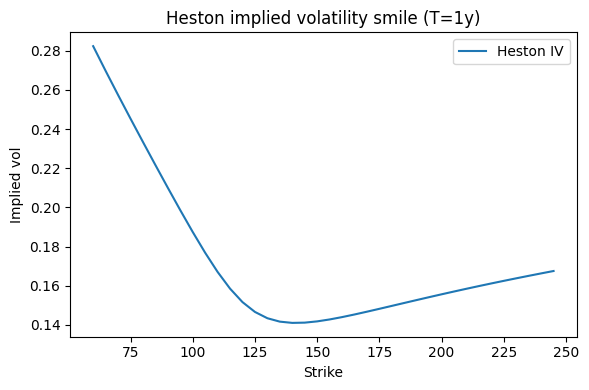

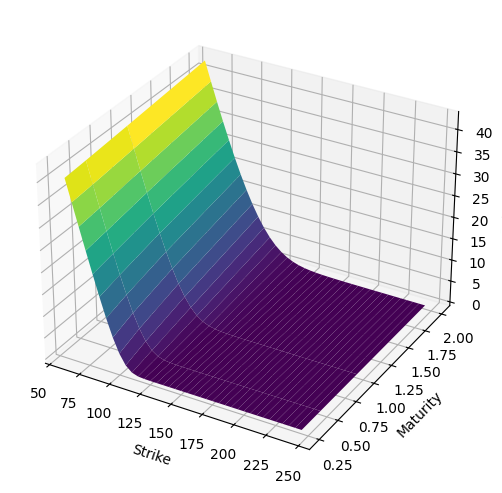

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from src.models.heston import heston_price_vectorized

try:
    from src.utils.helpers import HestonParams, safe_implied_volatility
except ImportError:
    import src.utils.helpers as helpers
    helpers = importlib.reload(helpers)
    HestonParams = helpers.HestonParams
    safe_implied_volatility = helpers.safe_implied_volatility

S0, r, q = 100.0, 0.02, 0.0
params = HestonParams(kappa=1.5, theta=0.04, sigma=0.4, rho=-0.7, v0=0.04)
strikes = np.arange(60, 250, 5)
maturities = np.array([0.25, 0.5, 1.0, 2.0])
prices = heston_price_vectorized(S0, strikes, maturities, r, q, params, option_type='call')

# Implied vol smile at T=1.0 using robust IV inversion
T_idx = np.where(np.isclose(maturities, 1.0))[0][0]
smile_prices = prices[T_idx]
smile_iv = np.array([safe_implied_volatility(p, S0, k, maturities[T_idx], r, q, 'call') for k, p in zip(strikes, smile_prices)])
mask = np.isfinite(smile_iv)

plt.figure(figsize=(6,4))
plt.plot(strikes[mask], smile_iv[mask], label='Heston IV')
plt.xlabel('Strike')
plt.ylabel('Implied vol')
plt.title('Heston implied volatility smile (T=1y)')
plt.legend()
plt.tight_layout()
plt.savefig('../reports/figures/heston_iv_smile_T1y.png', dpi=200, bbox_inches='tight')
plt.show()

# Price surface
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
X, Y = np.meshgrid(strikes, maturities)
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, prices, cmap='viridis')
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Call price')
plt.tight_layout()
plt.savefig('../reports/figures/heston_surface.png', dpi=150)
plt.show()


## Sanity checks
Heston should reduce to Black--Scholes in the constant-vol limit (sigma -> 0, v0=theta).


In [3]:
import importlib
import src.utils.helpers as helpers
helpers = importlib.reload(helpers)
from src.utils.helpers import diagnose_atm_price
print('ATM diagnostics for default params:')
diag = diagnose_atm_price(params, S0=S0, r=r, q=q, T=1.0)
print('P1:', diag.get('P1'), 'P2:', diag.get('P2'))


ATM diagnostics for default params:
{'heston_price': 8.424693922118273, 'bs_price': 8.916037278572539, 'heston_iv': 0.1874346968769613, 'P1': 0.6647698925559931, 'P2': 0.5922502949084634}
P1: 0.6647698925559931 P2: 0.5922502949084634


In [9]:
# No-arbitrage bounds check for the smile strikes
try:
    from src.utils.helpers import check_call_no_arbitrage
except ImportError:
    import importlib, src.utils.helpers as helpers
    helpers = importlib.reload(helpers)
    check_call_no_arbitrage = helpers.check_call_no_arbitrage
check_call_no_arbitrage(smile_prices, strikes, maturities[T_idx], S0, r, q)
print('No-arbitrage bounds satisfied for T=1.0 strikes.')


No-arbitrage bounds satisfied for T=1.0 strikes.


In [10]:
# Diagnostics for the IV smile computation
print('Strikes:', len(strikes))
finite_iv = np.isfinite(smile_iv)
print('Finite IV count:', finite_iv.sum())
print('Strike range:', strikes.min(), strikes.max())
if finite_iv.any():
    print('IV range:', float(smile_iv[finite_iv].min()), float(smile_iv[finite_iv].max()))


Strikes: 17
Finite IV count: 17
Strike range: 60 140
IV range: 0.14101109455843644 0.28230773646976864
